# Neural Network Binary Fraud Detection Dataset:
A basic implementation of the sampled binary Neural Network with Explainability which includes:
- Encoding categorical features with the encoder classes.
- Viewing the distribution of majority labels using a visualiser.
- Preprocessing data for a Neural Network.
- Optimising the Neural Network and saving it to a folder.
- Loading a saved Neural Network from the given path.
- Evaluating Training and Test set results.
- Integrating the results into shap using the Shap Manager Class.

In [1]:
# Check the working directory and set it to the main folder if needed.
# Set the directory to the main directory for imports.
import os
os.getcwd()

'C:\\Users\\matyc\\OneDrive\\Desktop\\UO_CaptoneProject2\\UniSA_ICT_2025-SP1-P4-Explainable-AI-for-Cyber-Threat-Detection-1\\UserGuides'

In [2]:
# Changing to main directory for Module imports.
os.chdir('../')

Imports and Dependencies. Most modules will be loaded as they are needed for explainability.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

#For the alternative dataset parts of the code
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import time

We load a given dataset that should be placed in the Data folder in UserGuide. For this we will use the current data. This is a binary classification example so the dataset used should be binary.

In [4]:
# Preprocess.
data = pd.read_csv('C:/Users/matyc/OneDrive/Desktop/UO_CaptoneProject2/UniSA_ICT_2025-SP1-P4-Explainable-AI-for-Cyber-Threat-Detection-1/UserGuides/Data/FraudDetectionDataset.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# A little bit of extra cleaning.
#data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
#data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
#data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

#Dropping these coloumns as they are almost 100% unique values
data = data.drop(columns=['nameOrig', 'nameDest']) 

For the purpose of simplifying the the example we use a smaller sample.

In [5]:
data = data.sample(n=1000000)
# Need to reset the index otherwise we can get Nulls.
data = data.reset_index(drop=True)

Now we find our categorical features. Here we want to make sure we don't include any features that are actually labels. In this case its 'attack_cat'.
Keep in mind that at times they may be of type 'category' instead where we would use 'category' instead of 'object' as a dtype.

In [6]:
categories = data.select_dtypes(include='object').columns.tolist()
print(categories)
# We remove attack_cat from the list: (no category target variable in this one)
#if 'type' in categories:
#    categories.remove('type')
#print(categories)

['type']


Because the Neural Network requires categories to be one-hot encoded we use the correlation one-hot encoder to get the most relevant features based on certain thresholds. Since we have a binary classification label this becomes particularly useful. The procedure goes through each value inside a categorical feature and converts it to a binary. Then it calculates the correlation for two binaries (Phi coefficient) between it and the label which in this case is the threat label. The encoder also helps to deal with memory allocation issues. If we were to to one-hot encode all the values, we will get an error as we would have an array of more than approximately 5,750,000,000 values. It also spares us the effort drawing the correlation seperately and inputing it into the OneHotEncoder class as it is all automatic.

In [7]:
# Import the correlation encoder.
from Tools.encoders import CorrOnehotEncoder
# Print the docstring.
help(CorrOnehotEncoder)

Help on class CorrOnehotEncoder in module Tools.encoders:

class CorrOnehotEncoder(builtins.object)
 |  CorrOnehotEncoder(column, target)
 |
 |  CorrOnehotEncoder: Encodes the given column by creating one-hot encoded columns for categories that have
 |  a correlation higher than a threshold with the target column.
 |
 |  Methods defined here:
 |
 |  __init__(self, column, target)
 |      Parameters:
 |          - column (pd.Series) The feature column to encode.
 |          - target (pd.Series) The target column.
 |
 |  corr(self, x, y)
 |      Calculate the Pearson correlation coefficient (Phi).
 |
 |      Parameters:
 |          - x (tensor - float32) The first variable.
 |          - y (tensor - float32) The target to draw correlation to.
 |
 |      Returns:
 |          - r (float32) The Pearson correlation coefficient (Phi).
 |
 |  encode(self, sparse_n, threshold, max_encoded)
 |      Encode the feature column by creating one-hot encoded columns for categories that have
 |      a c

In [8]:
# Parameters:
# The minimum number of 1's in the value (deals with sparse data). Since we are using sample data of 100, 000 we keep this pretty low. This parameter also significantly
# impacts the time to encode data. The higher the sparse_n value, the less values are calculated. However having a high value could potentially lead to worse accuracy.
sparse_n = 10000
# The threshold for correlation. 0 means the binary must have atleast some correlation. Correlation is collected for positive and negative instances. Ideally you we want this
# to be as close to 0 as possible as it will collect as many relevant features as possible for the evaluation phase (when we want to see how features interact with threats). 
# For example purposes we increase it to 0.1. A good check to do is to see how many unique values exist in the categorical variable before putting it through.
threshold = 0.01
# The limit for the encoded features. After collecting correlation the highest correlated values are sorted (highest to lowest) and the maximum is selected.
max_encoded = 50

ce = CorrOnehotEncoder(data['type'], data['isFraud'])
ohe1 = ce.encode(sparse_n, threshold, max_encoded)


Before adding the data back in lets take a quick look at what the data looks like for Normal labels (the majority label). We can evaluate how noisy the data is in the label based on different scalers. The cluster visualiser is limited to looking at continous data so will need to filter out binaries and discreet variables with small amounts of unique values.

In [9]:
# Create a new dataset with just Normal labels and make sure to drop the categorical columns from before.
cluster_data = data.drop(columns=categories)
# Now we set it to just Normal labels.
# I added isFraud == 0 in this instance
cluster_data = cluster_data[cluster_data['isFraud'] == 0]

In [10]:
# Now we try and filter for mostly continuous variables.
# Collect variables.
remove = []
for i in cluster_data:
    if len(cluster_data[i].unique()) < 30:
        remove.append(i)
# Drop the varibles collected.
cluster_data = cluster_data.drop(columns=remove)

In [11]:
# Import the cluster visualiser and read doc.
from Tools.cluster_visualiser import PlotClusters
# Read the docs.
help(PlotClusters)

Help on class PlotClusters in module Tools.cluster_visualiser:

class PlotClusters(builtins.object)
 |  PlotClusters(data, scaler_type, sample_size)
 |
 |  PlotClusters: A class that plots different clusters in a 3-D plot with augmentations. Easily evaluate K-means++ clusters or use DBSCAN to seperate noise from other clusters.
 |  Use either just the normal Kmeans++ to 3D or DBSCAN to 3D or optionally project it through TSNE. Makes it easy to quickly visualise within label groups.
 |
 |  Methods defined here:
 |
 |  __init__(self, data, scaler_type, sample_size)
 |      Parameters:
 |          - data (pd.DataFrame) The Dataset to analyse which should have the labels filtered out.
 |          - scaler_type (string) Either use 'standard' or 'minmax' scaler.
 |          - sample_size (int) Sample a smaller size - increasing this to above 10000 significantly increasing computation for TSNE.
 |
 |  plot_dbscan(self, eps=0.5, min_samples=20)
 |      plot_tsne:  DBSCAN clustering and visuali

We will use TSNE so we do not have to reduce our data using PCA. This will allow us to visualise more points. The problem with 2D planes and PCA is that we lose explainability based on the cumulative percentage of PCA components. TSNE does a much better job at capturing the data. We combine this with DBScan which helps us to plot the noise in the data as red dots. Lets check what the data looks like when we use Standard Scaling and Min Max Scaling.

Standard Scaler

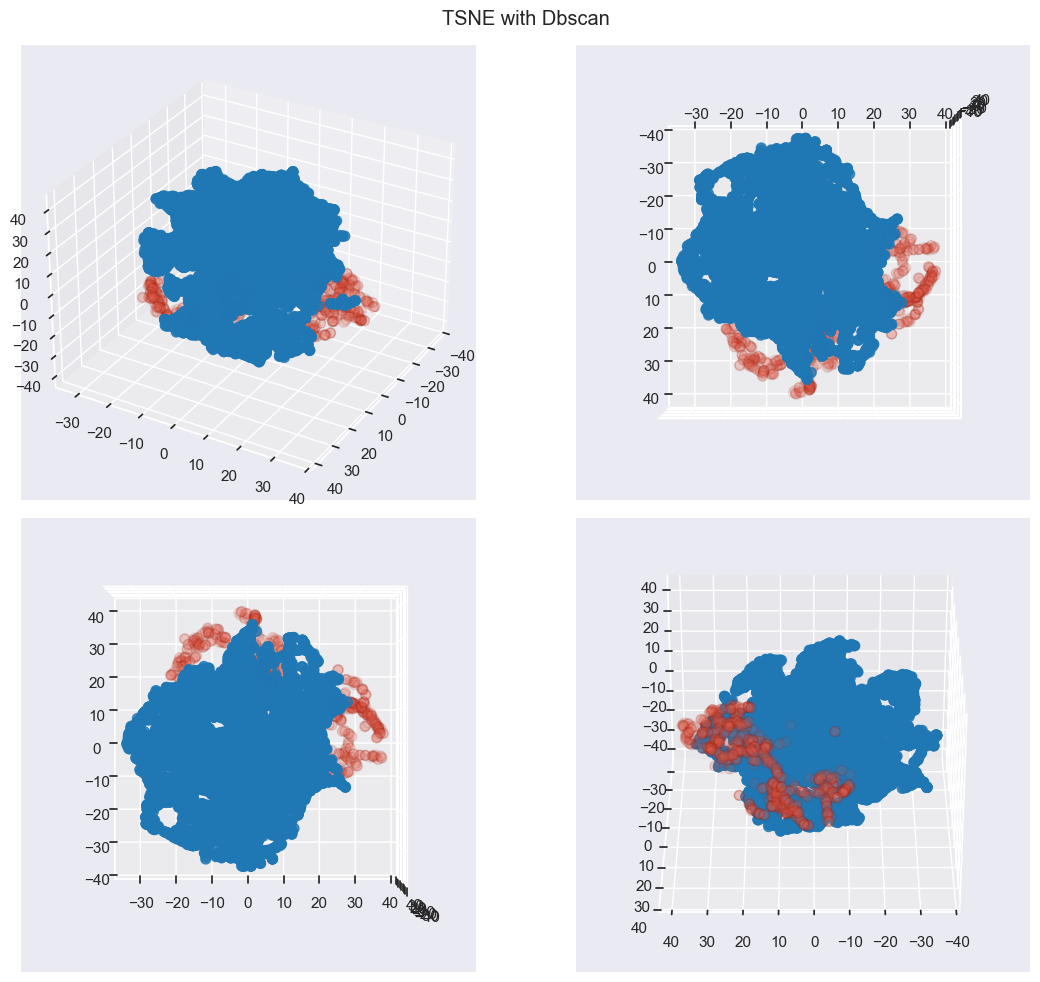

In [12]:
# Check Standard scaling data.
scaler = 'standard'
# Select the same size as all the currently sampled data. A limit of 10000 is recommended as TSNE is computationally expensive.
sample_size = 10000
pc = PlotClusters(cluster_data, scaler, sample_size)
# Ommit PCA conversion.
apply_pca = False
# DBSCAN doesnt use clusters.
n_clusters = None
# Learning rate for TSNE - this sometimes impacts the shape we get in the plots. We will set it to automatic.
learning_rate = 'auto'
# The perplexity directly affects the shape output of TSNE. Can at sometimes be pretty random but 30 usually works quite well. As we increase it towards 100 we get more stringy
# type results.
perplexity=10  #MATT Reduced perplexity to 10 for slightly better visual
# Select DBScan type clusters.
cluster_type = 'dbscan'
# Epsilon is the threshold for noise. It decides the ring (epsilon) at which to classify the points as noise or not.
epsilon = 0.5
pc.plot_tsne(apply_pca, n_clusters, learning_rate, perplexity, cluster_type, epsilon)

Now Lets Check Min-Max Scaling.

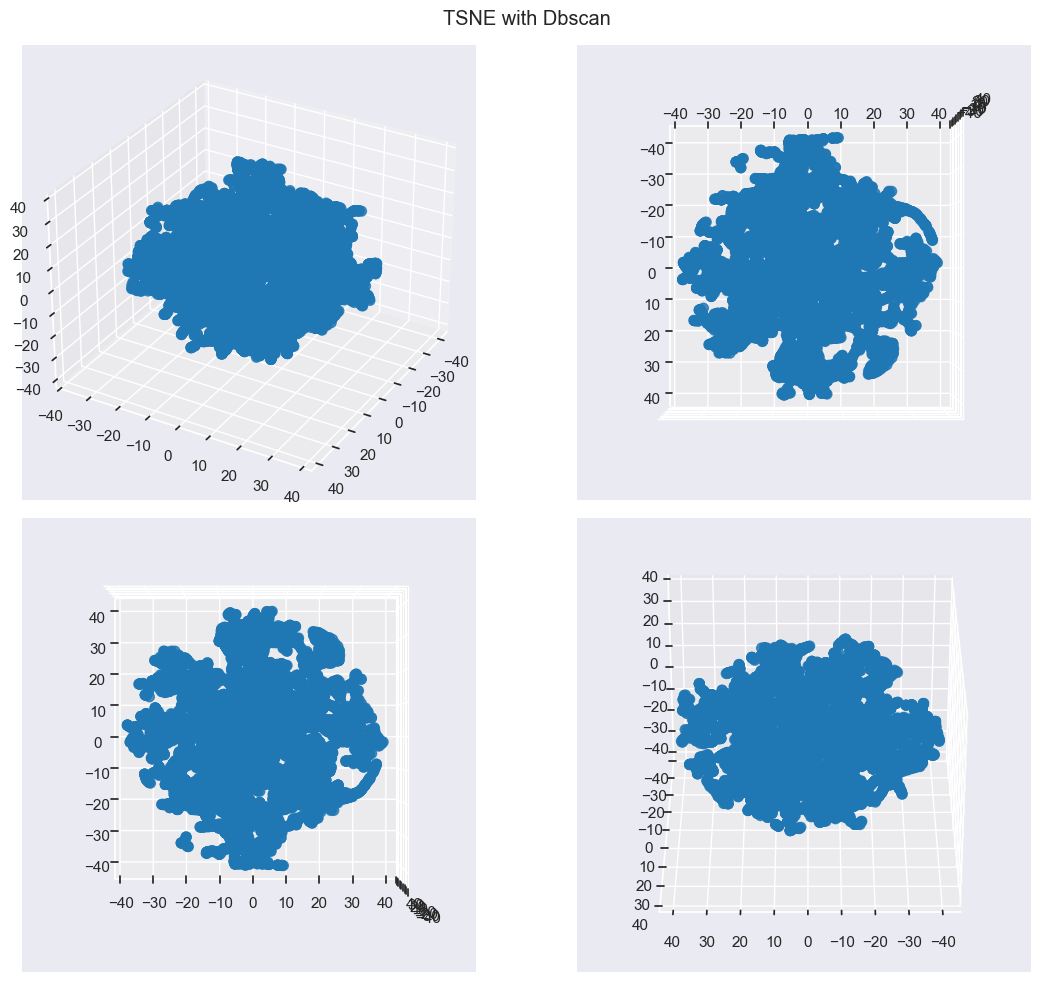

In [13]:
# Check Min-Max scaling data.
scaler = 'minmax'
# Select the same size as all the currently sampled data. A limit of 10000 is recommended as TSNE is computationally expensive.
sample_size = 10000
pc = PlotClusters(cluster_data, scaler, sample_size)
# Ommit PCA conversion.
apply_pca = False
# DBSCAN doesnt use clusters.
n_clusters = None
# Learning rate for TSNE - this sometimes impacts the shape we get in the plots. We will set it to automatic.
learning_rate = 'auto'
# The perplexity directly affects the shape output of TSNE. Can at sometimes be pretty random but 30 usually works quite well. As we increase it towards 100 we get more stringy
# type results.
perplexity=10
# Select DBScan type clusters.
cluster_type = 'dbscan'
# Epsilon is the threshold for noise. It decides the ring (epsilon) at which to classify the points as noise or not.
epsilon = 0.5
pc.plot_tsne(apply_pca, n_clusters, learning_rate, perplexity, cluster_type, epsilon)

Scaling data is effective for Neural Networks. It helps to reduce the overload of large distances between points. However this comes at a cost. Once the data is scaled the distance is lost meaning that the variables can only be described as being higher or lower with respect to themselves rather than real points in space. We see that noise is presumably reduced in Normal labels when using min-max scaling based on the same epsilon and will go forward as using that as our scaler in the Neural Network. Now lets continue pre-processing the data by scaling it and recombining the encoded features.

In [14]:
 #Drop the one-hot encoded features from the actual dataset.
#For some reason they have already been removed???
data = data.drop(columns=['type'])
# We put binaries and labels (label, attack_cat) in a temp DataFrame and scale all other variables.

temp = data[['isFlaggedFraud', 'isFraud']]
data = data.drop(columns=['isFlaggedFraud', 'isFraud'])

In [15]:
# Now scale the data using min-max scaler.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [16]:
# Recombine all the datasets.
# First we need to create the scaled_data into a DataFrame as I think it returns a numpy array.
data = pd.DataFrame(scaled_data, columns=data.columns)
# Then recombine the data.
data = pd.concat([data, temp, ohe1], axis=1)

Now we process the data further by splitting it into a training and test set. Generally for Neural Networks we would use a validation set. But in this case we are ommiting it.

In [17]:
# First remove the labels in the actual data.
X_temp = data.drop(columns=['isFraud'])
# Set y1 as the binary label.
y1 = data['isFraud']
# Split the data into 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y1, test_size=0.2, random_state=42)

DataLoader objects and Neural Networks through the torch framework require tensors so the data needs to be converted further. The Dataloader object allows for the data to be fed into the network in batches. If we select a batch size of 128 that means the training and test data are split into 128 pieces and fed in one after the other.

In [18]:
# Select the batch size. This directly impacts the effectiveness of some sampling methods.
batch_size = 128
# Convert each train and test set into tensors.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Convert to a Tensor Dataset which stores both the train and test sets.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add the Tensor Datasets into a DataLoader object which manages the batching. Shuffle function is used on the train set but not the test set.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Import and Set Up the Neural Network. Lets use SMOTE upsampling technique. SMOTE takes the minority labels in the batch (in this case threats) and upsamples them to the majority labels. This means for each batch if there is 20 Threat labels and 100 Normal, SMOTE will synthetically create 80 more threat labels and make them equal (100, 100). This is useful when the minority class is much lower because it becomes hard to predict and usually we get an imbalance where we get a high accuracy on majority labels but low accuracy on minority labels. By using SMOTE we balance this out and usually get the reverse where we significantly increase minority label (threat) predictions at the cost of incorrectly predicting some majority labels (Normal).

In [19]:
# Import the Neural Network and supporting functions.
from Models.models import NNdynamic, plot_metrics, plot_confusion_matrix
# read the Neural Network docs.
help(NNdynamic)

Help on class NNdynamic in module Models.models:

class NNdynamic(torch.nn.modules.module.Module)
 |  NNdynamic(n_features, fc_size, device, save_dir)
 |
 |  NNdynamic: A dynamic Neural Network which can implement different sampling techniques from imb-learn in the training pass to handle imbalanced classes. Alternatively,
 |  use the standard NN model.The process selects a sampler and implements it within the batches. The batch size influences the potential for sample to fail where it defaults
 |  back to a normal sample. In general large batch sizes tend to result in less errors.
 |
 |  Initialisation:
 |      - n_features (int) The number of features used in the data.
 |      - fc_size (int) The size of the dense layer which directly impacts complexity into shap calculations (weights | parameters).
 |      - device (torch.device) The device to calculate the tensor processes (currently only tested with cpu).
 |      - save_dir (string) The path to save the NN object. Saves using the 

In [20]:
# We can normally run tensors on the GPU but are still getting potential errors so will force it to a cpu for this example.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# The number of features which we have in the dataset.
n_features = X_train_tensor.shape[1]
# The dense layer size. This is the complexity of the dense (fully connected) layer. This is a type of communication between the arrays where each column (feature)
# communicates with every other column. In general the Neural Network has this kind of layer expansion, runs an activation function, then contracts it down to the number
# of labels we want to predict which in this case is 2.
fc_size = 256
# This is the directory to save to. Create a Test folder in the Models/saved_models folder. Make sure to add the ./ - for some reason I get errors otherwise.
save_dir = './Models/saved_models/FraudDetect'
# Create the model with the input parameters.
model = NNdynamic(n_features, fc_size, device, save_dir)
# Set the sampler to 'smote'
#sampler = 'smote'
sampler = None
# Set the sampling strategy to 'auto'. Since it is binary it will focus on sampling the minority class up to the majority class.
params = None
#params = {'sampling_strategy': 'auto'}
# We will decrease the learning rate so we can create some visuals that show how the model trains over each epoch. The lower the learning rate, the less likely we are
# going to overshoot the minimum. However the lowest loss might not be always desirable when using sampling methods such as SMOTE and focusing on threats.
learning_rate = 0.001
# The number of loops over the whole dataset.
epochs = 50
# The save factor we can save the Model for each epoch then reload the best performing one after.
save_factor = 5
# Now run the model.
model.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)

Epoch 1/50: 100%|██████████| 6250/6250 [00:26<00:00, 235.84batch/s]


Epoch [1/50], Train Loss: 0.0113, Train Acc: 0.9988, Train F1: 0.9982


Epoch 2/50: 100%|██████████| 6250/6250 [00:26<00:00, 235.97batch/s]


Epoch [2/50], Train Loss: 0.0058, Train Acc: 0.9989, Train F1: 0.9984


Epoch 3/50: 100%|██████████| 6250/6250 [00:27<00:00, 227.16batch/s]


Epoch [3/50], Train Loss: 0.0048, Train Acc: 0.9991, Train F1: 0.9987


Epoch 4/50: 100%|██████████| 6250/6250 [00:25<00:00, 241.40batch/s]


Epoch [4/50], Train Loss: 0.0043, Train Acc: 0.9992, Train F1: 0.9988


Epoch 5/50: 100%|██████████| 6250/6250 [00:26<00:00, 231.55batch/s]


Epoch [5/50], Train Loss: 0.0039, Train Acc: 0.9992, Train F1: 0.9988


Epoch 6/50: 100%|██████████| 6250/6250 [00:30<00:00, 205.78batch/s]


Epoch [6/50], Train Loss: 0.0037, Train Acc: 0.9992, Train F1: 0.9989


Epoch 7/50: 100%|██████████| 6250/6250 [00:29<00:00, 208.43batch/s]


Epoch [7/50], Train Loss: 0.0036, Train Acc: 0.9993, Train F1: 0.9989


Epoch 8/50: 100%|██████████| 6250/6250 [00:31<00:00, 199.26batch/s]


Epoch [8/50], Train Loss: 0.0035, Train Acc: 0.9993, Train F1: 0.9989


Epoch 9/50: 100%|██████████| 6250/6250 [00:31<00:00, 200.28batch/s]


Epoch [9/50], Train Loss: 0.0035, Train Acc: 0.9993, Train F1: 0.9990


Epoch 10/50: 100%|██████████| 6250/6250 [00:31<00:00, 200.39batch/s]


Epoch [10/50], Train Loss: 0.0034, Train Acc: 0.9993, Train F1: 0.9990


Epoch 11/50: 100%|██████████| 6250/6250 [00:31<00:00, 198.08batch/s]


Epoch [11/50], Train Loss: 0.0033, Train Acc: 0.9993, Train F1: 0.9990


Epoch 12/50: 100%|██████████| 6250/6250 [00:32<00:00, 189.83batch/s]


Epoch [12/50], Train Loss: 0.0033, Train Acc: 0.9993, Train F1: 0.9990


Epoch 13/50: 100%|██████████| 6250/6250 [00:30<00:00, 201.66batch/s]


Epoch [13/50], Train Loss: 0.0032, Train Acc: 0.9993, Train F1: 0.9990


Epoch 14/50: 100%|██████████| 6250/6250 [00:32<00:00, 193.36batch/s]


Epoch [14/50], Train Loss: 0.0032, Train Acc: 0.9993, Train F1: 0.9990


Epoch 15/50: 100%|██████████| 6250/6250 [00:32<00:00, 189.61batch/s]


Epoch [15/50], Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9990


Epoch 16/50: 100%|██████████| 6250/6250 [00:32<00:00, 191.41batch/s]


Epoch [16/50], Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9990


Epoch 17/50: 100%|██████████| 6250/6250 [00:32<00:00, 190.31batch/s]


Epoch [17/50], Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9990


Epoch 18/50: 100%|██████████| 6250/6250 [00:31<00:00, 196.39batch/s]


Epoch [18/50], Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9991


Epoch 19/50: 100%|██████████| 6250/6250 [00:33<00:00, 189.24batch/s]


Epoch [19/50], Train Loss: 0.0030, Train Acc: 0.9993, Train F1: 0.9991


Epoch 20/50: 100%|██████████| 6250/6250 [00:31<00:00, 196.59batch/s]


Epoch [20/50], Train Loss: 0.0030, Train Acc: 0.9994, Train F1: 0.9991


Epoch 21/50: 100%|██████████| 6250/6250 [00:30<00:00, 201.86batch/s]


Epoch [21/50], Train Loss: 0.0030, Train Acc: 0.9994, Train F1: 0.9991


Epoch 22/50: 100%|██████████| 6250/6250 [00:30<00:00, 202.22batch/s]


Epoch [22/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9991


Epoch 23/50: 100%|██████████| 6250/6250 [00:32<00:00, 194.77batch/s]


Epoch [23/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9991


Epoch 24/50: 100%|██████████| 6250/6250 [00:30<00:00, 203.58batch/s]


Epoch [24/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9991


Epoch 25/50: 100%|██████████| 6250/6250 [00:32<00:00, 190.54batch/s]


Epoch [25/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9991


Epoch 26/50: 100%|██████████| 6250/6250 [00:29<00:00, 210.49batch/s]


Epoch [26/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 27/50: 100%|██████████| 6250/6250 [00:30<00:00, 207.22batch/s]


Epoch [27/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 28/50: 100%|██████████| 6250/6250 [00:28<00:00, 216.85batch/s]


Epoch [28/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 29/50: 100%|██████████| 6250/6250 [00:28<00:00, 216.63batch/s]


Epoch [29/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 30/50: 100%|██████████| 6250/6250 [00:28<00:00, 217.22batch/s]


Epoch [30/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9991


Epoch 31/50: 100%|██████████| 6250/6250 [00:28<00:00, 218.20batch/s]


Epoch [31/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9992


Epoch 32/50: 100%|██████████| 6250/6250 [00:28<00:00, 219.05batch/s]


Epoch [32/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9992


Epoch 33/50: 100%|██████████| 6250/6250 [00:27<00:00, 227.77batch/s]


Epoch [33/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9992


Epoch 34/50: 100%|██████████| 6250/6250 [00:27<00:00, 224.08batch/s]


Epoch [34/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9991


Epoch 35/50: 100%|██████████| 6250/6250 [00:27<00:00, 225.79batch/s]


Epoch [35/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 36/50: 100%|██████████| 6250/6250 [00:27<00:00, 223.64batch/s]


Epoch [36/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 37/50: 100%|██████████| 6250/6250 [00:27<00:00, 224.68batch/s]


Epoch [37/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 38/50: 100%|██████████| 6250/6250 [00:27<00:00, 231.46batch/s]


Epoch [38/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 39/50: 100%|██████████| 6250/6250 [00:26<00:00, 233.76batch/s]


Epoch [39/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 40/50: 100%|██████████| 6250/6250 [00:30<00:00, 205.41batch/s]


Epoch [40/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 41/50: 100%|██████████| 6250/6250 [00:30<00:00, 204.51batch/s]


Epoch [41/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 42/50: 100%|██████████| 6250/6250 [00:30<00:00, 206.68batch/s]


Epoch [42/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 43/50: 100%|██████████| 6250/6250 [00:30<00:00, 202.28batch/s]


Epoch [43/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 44/50: 100%|██████████| 6250/6250 [00:30<00:00, 208.01batch/s]


Epoch [44/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 45/50: 100%|██████████| 6250/6250 [00:29<00:00, 211.99batch/s]


Epoch [45/50], Train Loss: 0.0024, Train Acc: 0.9994, Train F1: 0.9992


Epoch 46/50: 100%|██████████| 6250/6250 [00:28<00:00, 218.12batch/s]


Epoch [46/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 47/50: 100%|██████████| 6250/6250 [00:30<00:00, 207.02batch/s]


Epoch [47/50], Train Loss: 0.0024, Train Acc: 0.9995, Train F1: 0.9992


Epoch 48/50: 100%|██████████| 6250/6250 [00:29<00:00, 214.68batch/s]


Epoch [48/50], Train Loss: 0.0024, Train Acc: 0.9995, Train F1: 0.9992


Epoch 49/50: 100%|██████████| 6250/6250 [00:30<00:00, 205.30batch/s]


Epoch [49/50], Train Loss: 0.0024, Train Acc: 0.9995, Train F1: 0.9992


Epoch 50/50: 100%|██████████| 6250/6250 [00:28<00:00, 221.94batch/s]

Epoch [50/50], Train Loss: 0.0024, Train Acc: 0.9995, Train F1: 0.9992


The Model has inbuilt parameters which help us view how the model is training. We can use the supporting functions in models to take a look at some of them.

In [22]:
# Read the plot_metrics doc.
help(plot_metrics)

Help on function plot_metrics in module Models.models:

plot_metrics(metric, epochs, title)
    Plot the training metrics for the NNsmote class.

    Parameter:
    - metric (list) Training metric (e.g. model.train_loss).
    - epochs (int) The number of epochs.
    - title (string) The title of the plot (imputes the category with type of plot).



Plot Loss

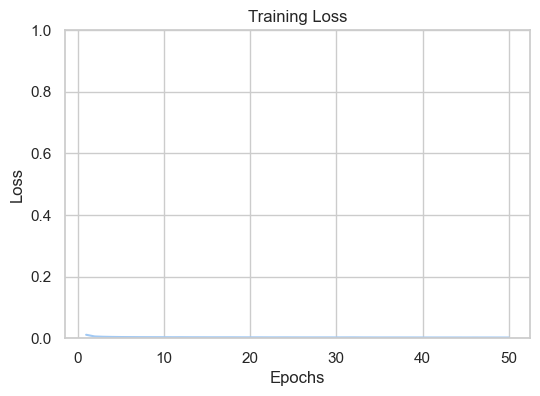

In [23]:
plot_metrics(model.train_loss, epochs=epochs, title='Loss')

Accuracy

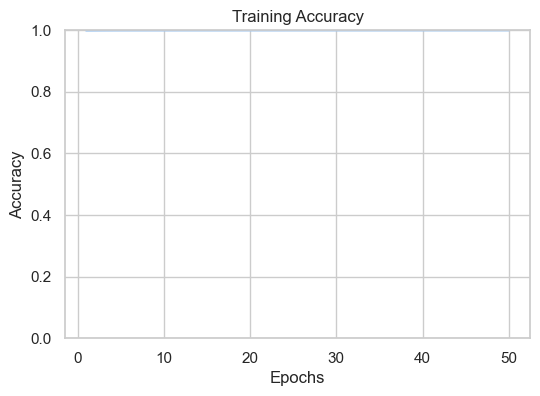

In [25]:
plot_metrics(model.train_accuracy, epochs=epochs, title='Accuracy')

F1 Macro which is the average F1 score across the epoch. This is a balance between Precision and Recall.

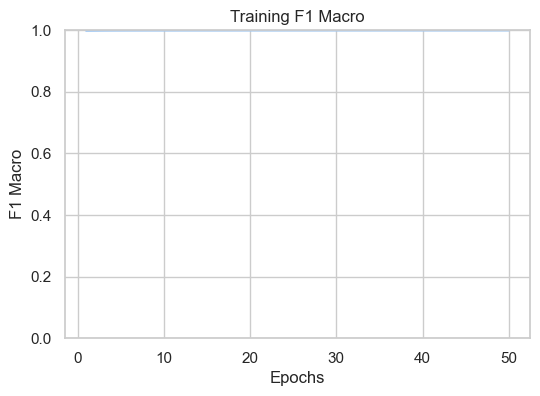

In [26]:
plot_metrics(model.train_f1, epochs=epochs, title='F1 Macro')

Epoch Time tells us on average how long each epoch took.

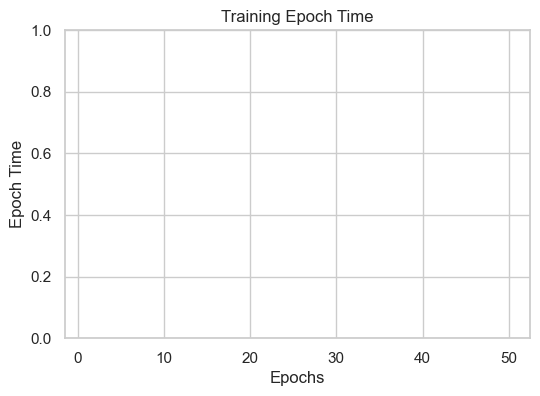

In [27]:
plot_metrics(model.epoch_time, epochs=epochs, title='Epoch Time')

In [24]:
# Run model on test set.
model.test(test_loader)

Testing: 100%|██████████| 1563/1563 [00:04<00:00, 356.80batch/s]


Test Loss: 0.0031, Test Accuracy: 0.9994, Test F1: 0.9992


In [37]:
print(classification_report(y_test, model.test_predicted, target_names=['Not Fraud', 'Fraud']))

# Time the forward pass
start = time.time()
with torch.no_grad():
    y_pred = model(X_test_tensor)
end = time.time()

print(f"Inference time: {end - start:.6f} seconds")

# Estimate FLOPs
n_samples = X_test_tensor.shape[0]
n_classes = 2  # Output layer size
flops_per_sample = (n_features * fc_size + fc_size * fc_size + fc_size * n_classes)
total_flops = flops_per_sample * n_samples
gflops = total_flops / ((end - start) * 1e9)

print(f"Estimated GFLOPS: {gflops:.6f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    199710
       Fraud       0.99      0.56      0.71       290

    accuracy                           1.00    200000
   macro avg       1.00      0.78      0.86    200000
weighted avg       1.00      1.00      1.00    200000

Inference time: 0.070451 seconds
Estimated GFLOPS: 195.494021


C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)
Te

Test Loss: 0.0046, Test Accuracy: 0.9991, Test F1: 0.9987


Testing: 100%|██████████| 1563/1563 [00:04<00:00, 318.45batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0043, Test Accuracy: 0.9992, Test F1: 0.9988


Testing: 100%|██████████| 1563/1563 [00:05<00:00, 310.29batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0038, Test Accuracy: 0.9993, Test F1: 0.9990


Testing: 100%|██████████| 1563/1563 [00:04<00:00, 316.37batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0042, Test Accuracy: 0.9993, Test F1: 0.9990


Testing: 100%|██████████| 1563/1563 [00:04<00:00, 321.99batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0037, Test Accuracy: 0.9993, Test F1: 0.9989


Testing: 100%|██████████| 1563/1563 [00:04<00:00, 343.95batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0036, Test Accuracy: 0.9993, Test F1: 0.9991


Testing: 100%|██████████| 1563/1563 [00:05<00:00, 273.37batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0038, Test Accuracy: 0.9993, Test F1: 0.9989


Testing: 100%|██████████| 1563/1563 [00:04<00:00, 321.30batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2560058258.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0033, Test Accuracy: 0.9994, Test F1: 0.9991


Testing: 100%|██████████| 1563/1563 [00:05<00:00, 309.68batch/s]


Test Loss: 0.0036, Test Accuracy: 0.9994, Test F1: 0.9990


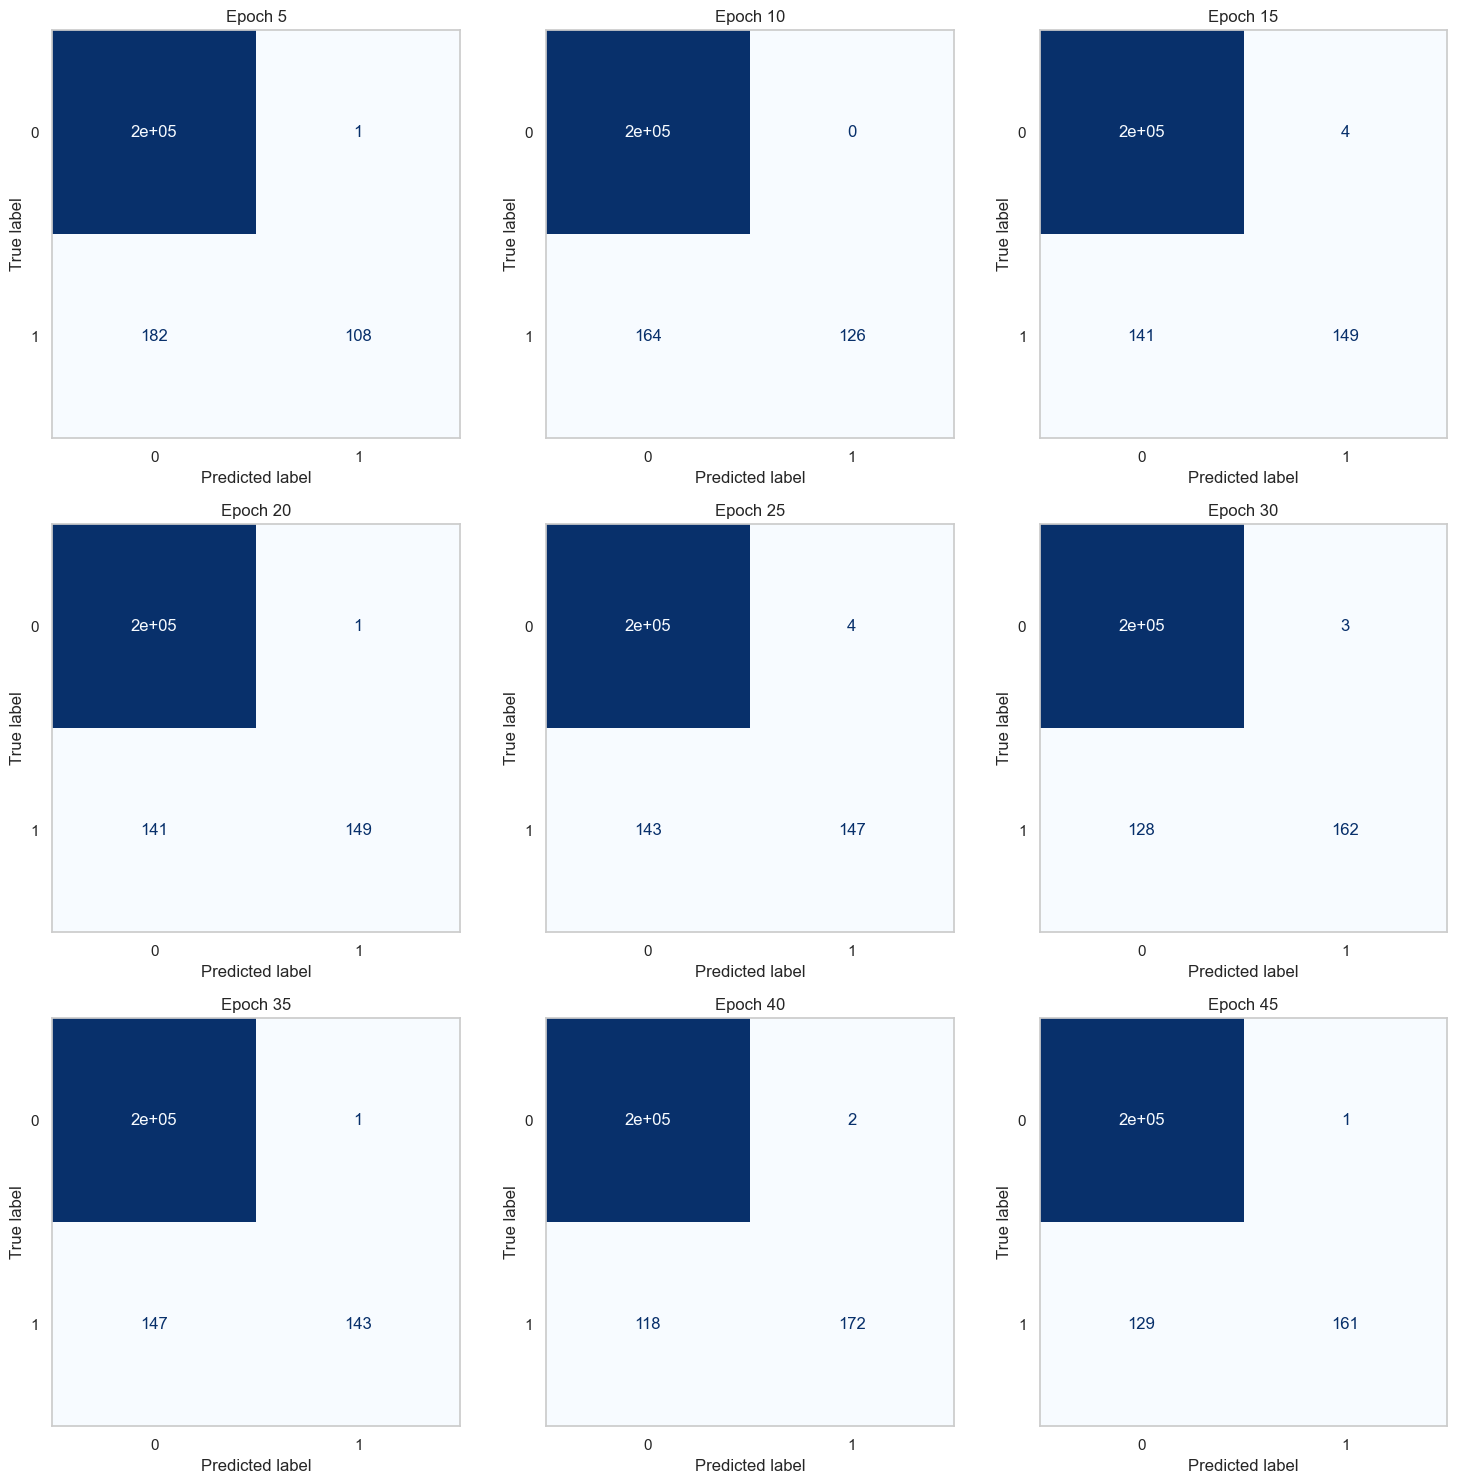

In [33]:
#This section shows all the confusion matrices for the save epoch of the model
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Set up number of subplots (one for each 5-epoch step)
epoch_list = list(range(5, epochs, 5))
n = len(epoch_list)
cols = 3
rows = (n + cols - 1) // cols  # Ensures enough rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for idx, i in enumerate(epoch_list):
    model_path = f"C:/Users/matyc/OneDrive/Desktop/UO_CaptoneProject2/UniSA_ICT_2025-SP1-P4-Explainable-AI-for-Cyber-Threat-Detection-1/Models/saved_models/FraudDetect/PB_epoch_{i}.pth"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.test(test_loader)

    # Convert both y_test and predicted labels to 1D numpy arrays
    y_true = np.ravel(np.asarray(y_test))
    y_pred = np.ravel(np.asarray(model.test_predicted))

    ax = axes[idx]
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        ax=ax,
        colorbar=False,
        cmap = "Blues"
        
    )
    ax.set_title(f"Epoch {i}")
    ax.grid(False)

# Hide unused subplots if any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Straight away we see that the loss is not as low as the training set meaning we potentially overfitted the model.

Most of the time we want to take it from the 'knee' at the epoch which is when the model significantly reduces decreasing loss and optimise it from there. This can be done using the load_model function and selecting the saved epoch.

In [34]:
# Check the docs for plot_confusion matrix.
help(plot_confusion_matrix)

Help on function plot_confusion_matrix in module Models.models:

plot_confusion_matrix(actual_labels, predicted_labels)
    Plot confusion matrix: Plot a confusion matrix using the results of the NNsmote class.

    Parameter:
    - actual_labels (tensor) The true labels of the data.
    - predicted_labels (tensor) The predicted labels from model.predicted_labels.



In [35]:
device = torch.device("cpu")
n_features = X_train_tensor.shape[1]
# Increase layer size.
fc_size = 256
save_dir = './Models/saved_models/FraudDetect'
model2 = NNdynamic(n_features, fc_size, device, save_dir)
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
# Increase learning rate.
learning_rate = 0.01
# We decrease epochs as a higher learning rate tend to converge faster.
epochs = 50
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)


Epoch 1/50: 100%|██████████| 6250/6250 [00:20<00:00, 302.79batch/s]


Epoch [1/50], Train Loss: 0.0066, Train Acc: 0.9989, Train F1: 0.9984


Epoch 2/50: 100%|██████████| 6250/6250 [00:22<00:00, 282.95batch/s]


Epoch [2/50], Train Loss: 0.0046, Train Acc: 0.9992, Train F1: 0.9988


Epoch 3/50: 100%|██████████| 6250/6250 [00:22<00:00, 272.56batch/s]


Epoch [3/50], Train Loss: 0.0041, Train Acc: 0.9992, Train F1: 0.9989


Epoch 4/50: 100%|██████████| 6250/6250 [00:22<00:00, 276.39batch/s]


Epoch [4/50], Train Loss: 0.0039, Train Acc: 0.9992, Train F1: 0.9989


Epoch 5/50: 100%|██████████| 6250/6250 [00:22<00:00, 279.88batch/s]


Epoch [5/50], Train Loss: 0.0039, Train Acc: 0.9993, Train F1: 0.9989


Epoch 6/50: 100%|██████████| 6250/6250 [00:21<00:00, 284.21batch/s]


Epoch [6/50], Train Loss: 0.0037, Train Acc: 0.9993, Train F1: 0.9990


Epoch 7/50: 100%|██████████| 6250/6250 [00:21<00:00, 286.49batch/s]


Epoch [7/50], Train Loss: 0.0037, Train Acc: 0.9993, Train F1: 0.9990


Epoch 8/50: 100%|██████████| 6250/6250 [00:20<00:00, 297.83batch/s]


Epoch [8/50], Train Loss: 0.0035, Train Acc: 0.9993, Train F1: 0.9990


Epoch 9/50: 100%|██████████| 6250/6250 [00:22<00:00, 282.59batch/s]


Epoch [9/50], Train Loss: 0.0035, Train Acc: 0.9993, Train F1: 0.9990


Epoch 10/50: 100%|██████████| 6250/6250 [00:22<00:00, 274.57batch/s]


Epoch [10/50], Train Loss: 0.0034, Train Acc: 0.9993, Train F1: 0.9990


Epoch 11/50: 100%|██████████| 6250/6250 [00:22<00:00, 277.61batch/s]


Epoch [11/50], Train Loss: 0.0034, Train Acc: 0.9993, Train F1: 0.9990


Epoch 12/50: 100%|██████████| 6250/6250 [00:22<00:00, 280.68batch/s]


Epoch [12/50], Train Loss: 0.0033, Train Acc: 0.9993, Train F1: 0.9990


Epoch 13/50: 100%|██████████| 6250/6250 [00:22<00:00, 282.73batch/s]


Epoch [13/50], Train Loss: 0.0033, Train Acc: 0.9993, Train F1: 0.9991


Epoch 14/50: 100%|██████████| 6250/6250 [00:22<00:00, 282.61batch/s]


Epoch [14/50], Train Loss: 0.0032, Train Acc: 0.9993, Train F1: 0.9990


Epoch 15/50: 100%|██████████| 6250/6250 [00:22<00:00, 281.01batch/s]


Epoch [15/50], Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9991


Epoch 16/50: 100%|██████████| 6250/6250 [00:22<00:00, 281.23batch/s]


Epoch [16/50], Train Loss: 0.0031, Train Acc: 0.9994, Train F1: 0.9991


Epoch 17/50: 100%|██████████| 6250/6250 [00:22<00:00, 283.17batch/s]


Epoch [17/50], Train Loss: 0.0032, Train Acc: 0.9994, Train F1: 0.9991


Epoch 18/50: 100%|██████████| 6250/6250 [00:22<00:00, 276.72batch/s]


Epoch [18/50], Train Loss: 0.0032, Train Acc: 0.9993, Train F1: 0.9991


Epoch 19/50: 100%|██████████| 6250/6250 [00:22<00:00, 273.99batch/s]


Epoch [19/50], Train Loss: 0.0032, Train Acc: 0.9994, Train F1: 0.9991


Epoch 20/50: 100%|██████████| 6250/6250 [00:22<00:00, 276.17batch/s]


Epoch [20/50], Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9991


Epoch 21/50: 100%|██████████| 6250/6250 [00:23<00:00, 269.19batch/s]


Epoch [21/50], Train Loss: 0.0030, Train Acc: 0.9994, Train F1: 0.9991


Epoch 22/50: 100%|██████████| 6250/6250 [00:22<00:00, 274.89batch/s]


Epoch [22/50], Train Loss: 0.0030, Train Acc: 0.9994, Train F1: 0.9991


Epoch 23/50: 100%|██████████| 6250/6250 [00:23<00:00, 270.53batch/s]


Epoch [23/50], Train Loss: 0.0030, Train Acc: 0.9994, Train F1: 0.9991


Epoch 24/50: 100%|██████████| 6250/6250 [00:22<00:00, 272.77batch/s]


Epoch [24/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9991


Epoch 25/50: 100%|██████████| 6250/6250 [00:22<00:00, 274.25batch/s]


Epoch [25/50], Train Loss: 0.0030, Train Acc: 0.9994, Train F1: 0.9991


Epoch 26/50: 100%|██████████| 6250/6250 [00:22<00:00, 281.82batch/s]


Epoch [26/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9992


Epoch 27/50: 100%|██████████| 6250/6250 [00:22<00:00, 277.61batch/s]


Epoch [27/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9991


Epoch 28/50: 100%|██████████| 6250/6250 [00:22<00:00, 271.96batch/s]


Epoch [28/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 29/50: 100%|██████████| 6250/6250 [00:23<00:00, 271.44batch/s]


Epoch [29/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 30/50: 100%|██████████| 6250/6250 [00:23<00:00, 271.16batch/s]


Epoch [30/50], Train Loss: 0.0031, Train Acc: 0.9994, Train F1: 0.9992


Epoch 31/50: 100%|██████████| 6250/6250 [00:22<00:00, 273.49batch/s]


Epoch [31/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9991


Epoch 32/50: 100%|██████████| 6250/6250 [00:22<00:00, 281.95batch/s]


Epoch [32/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9992


Epoch 33/50: 100%|██████████| 6250/6250 [00:22<00:00, 272.84batch/s]


Epoch [33/50], Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9992


Epoch 34/50: 100%|██████████| 6250/6250 [00:23<00:00, 261.57batch/s]


Epoch [34/50], Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9992


Epoch 35/50: 100%|██████████| 6250/6250 [00:23<00:00, 270.95batch/s]


Epoch [35/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9992


Epoch 36/50: 100%|██████████| 6250/6250 [00:23<00:00, 263.66batch/s]


Epoch [36/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 37/50: 100%|██████████| 6250/6250 [00:22<00:00, 272.29batch/s]


Epoch [37/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9992


Epoch 38/50: 100%|██████████| 6250/6250 [00:23<00:00, 269.69batch/s]


Epoch [38/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9992


Epoch 39/50: 100%|██████████| 6250/6250 [00:23<00:00, 269.85batch/s]


Epoch [39/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 40/50: 100%|██████████| 6250/6250 [00:23<00:00, 268.06batch/s]


Epoch [40/50], Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9992


Epoch 41/50: 100%|██████████| 6250/6250 [00:23<00:00, 265.53batch/s]


Epoch [41/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 42/50: 100%|██████████| 6250/6250 [00:23<00:00, 267.98batch/s]


Epoch [42/50], Train Loss: 0.0025, Train Acc: 0.9995, Train F1: 0.9992


Epoch 43/50: 100%|██████████| 6250/6250 [00:23<00:00, 269.35batch/s]


Epoch [43/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Epoch 44/50: 100%|██████████| 6250/6250 [00:23<00:00, 269.40batch/s]


Epoch [44/50], Train Loss: 0.0024, Train Acc: 0.9995, Train F1: 0.9992


Epoch 45/50: 100%|██████████| 6250/6250 [00:22<00:00, 272.46batch/s]


Epoch [45/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 46/50: 100%|██████████| 6250/6250 [00:22<00:00, 273.89batch/s]


Epoch [46/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 47/50: 100%|██████████| 6250/6250 [00:24<00:00, 260.14batch/s]


Epoch [47/50], Train Loss: 0.0025, Train Acc: 0.9994, Train F1: 0.9992


Epoch 48/50: 100%|██████████| 6250/6250 [00:25<00:00, 245.25batch/s]


Epoch [48/50], Train Loss: 0.0024, Train Acc: 0.9995, Train F1: 0.9992


Epoch 49/50: 100%|██████████| 6250/6250 [00:26<00:00, 239.59batch/s]


Epoch [49/50], Train Loss: 0.0024, Train Acc: 0.9994, Train F1: 0.9992


Epoch 50/50: 100%|██████████| 6250/6250 [00:25<00:00, 249.52batch/s]

Epoch [50/50], Train Loss: 0.0026, Train Acc: 0.9994, Train F1: 0.9992


Now run the model on test set and compare results.

In [36]:
model2.test(test_loader)

Testing: 100%|██████████| 1563/1563 [00:03<00:00, 464.67batch/s]

Test Loss: 0.0038, Test Accuracy: 0.9993, Test F1: 0.9989


In [38]:
print(classification_report(y_test, model2.test_predicted, target_names=['NotFraud', 'Fraud']))

# Time the forward pass
start = time.time()
with torch.no_grad():
    y_pred = model2(X_test_tensor)
end = time.time()

print(f"Inference time: {end - start:.6f} seconds")

# Estimate FLOPs
n_samples = X_test_tensor.shape[0]
n_classes = 2  # Output layer size
flops_per_sample = (n_features * fc_size + fc_size * fc_size + fc_size * n_classes)
total_flops = flops_per_sample * n_samples
gflops = total_flops / ((end - start) * 1e9)

print(f"Estimated GFLOPS: {gflops:.6f}")

              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    199710
       Fraud       1.00      0.50      0.66       290

    accuracy                           1.00    200000
   macro avg       1.00      0.75      0.83    200000
weighted avg       1.00      1.00      1.00    200000

Inference time: 0.047337 seconds
Estimated GFLOPS: 290.953235


Ok so this is what we want. Although we have an increase in false predictions in Normal labels (236), we have successfully train a model to predict all threats (0). Now we move to reducing false positives. If we get very good results with SMOTE we can pass over the correctly predicted minority labels into a secondary model. What is interesting is that we expect the Standard model to have the inverse behavior of the SMOTE model which can hopefully reduce false positives.

C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)
Te

Test Loss: 0.0051, Test Accuracy: 0.9991, Test F1: 0.9987


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 399.66batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0040, Test Accuracy: 0.9993, Test F1: 0.9989


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 397.18batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0066, Test Accuracy: 0.9991, Test F1: 0.9987


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 430.74batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0038, Test Accuracy: 0.9993, Test F1: 0.9990


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 424.11batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0051, Test Accuracy: 0.9993, Test F1: 0.9989


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 458.80batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0045, Test Accuracy: 0.9992, Test F1: 0.9989


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 442.08batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0037, Test Accuracy: 0.9992, Test F1: 0.9989


Testing: 100%|██████████| 1563/1563 [00:04<00:00, 374.34batch/s]
C:\Users\matyc\AppData\Local\Temp\ipykernel_18016\2821500634.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Test Loss: 0.0036, Test Accuracy: 0.9993, Test F1: 0.9990


Testing: 100%|██████████| 1563/1563 [00:03<00:00, 440.00batch/s]


Test Loss: 0.0041, Test Accuracy: 0.9993, Test F1: 0.9989


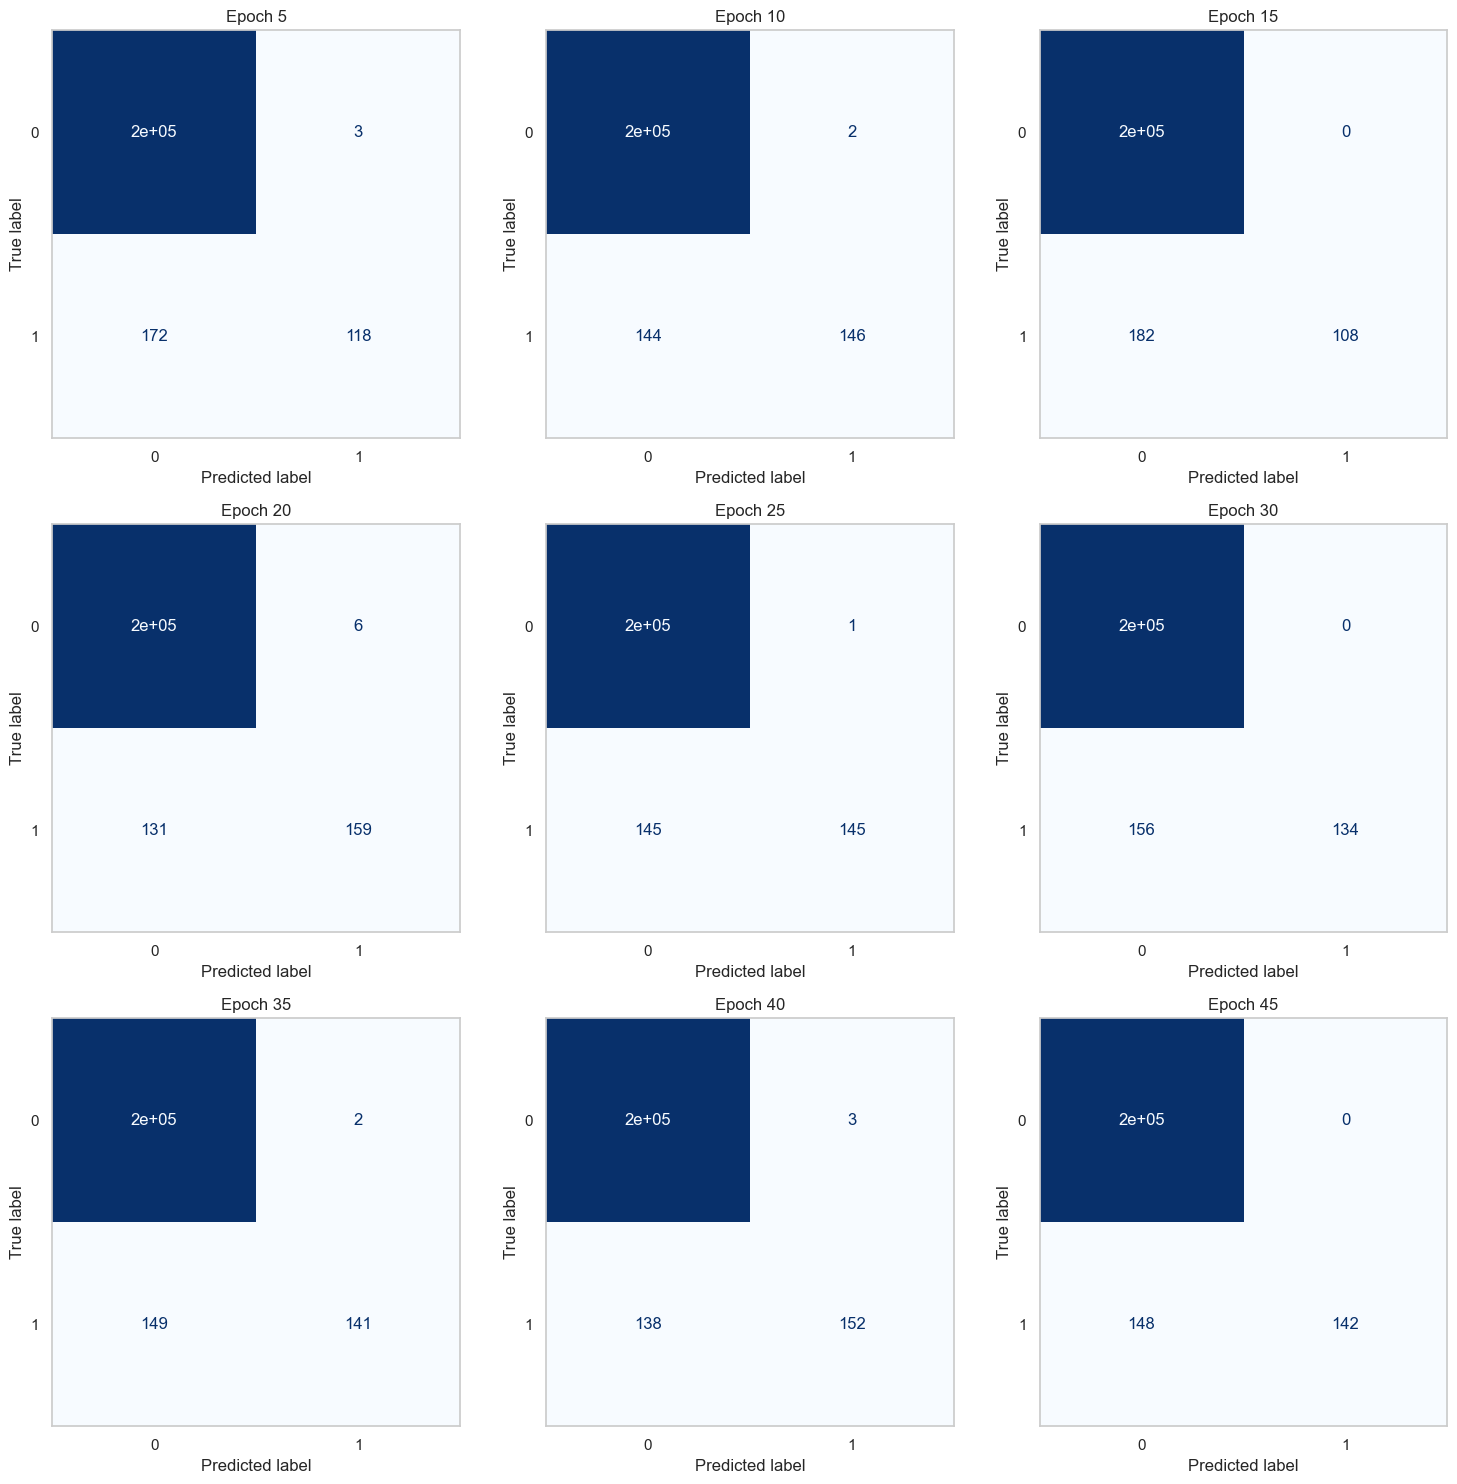

In [39]:
#This section shows all the confusion matrices for the save epoch of the model
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Set up number of subplots (one for each 5-epoch step)
epoch_list = list(range(5, epochs, 5))
n = len(epoch_list)
cols = 3
rows = (n + cols - 1) // cols  # Ensures enough rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for idx, i in enumerate(epoch_list):
    model_path = f"C:/Users/matyc/OneDrive/Desktop/UO_CaptoneProject2/UniSA_ICT_2025-SP1-P4-Explainable-AI-for-Cyber-Threat-Detection-1/Models/saved_models/FraudDetect/PB_epoch_{i}.pth"
    state_dict = torch.load(model_path, map_location=device)
    model2.load_state_dict(state_dict)
    model2.test(test_loader)

    # Convert both y_test and predicted labels to 1D numpy arrays
    y_true = np.ravel(np.asarray(y_test))
    y_pred = np.ravel(np.asarray(model2.test_predicted))

    ax = axes[idx]
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        ax=ax,
        colorbar=False,
        cmap = "Blues"
        
    )
    ax.set_title(f"Epoch {i}")
    ax.grid(False)

# Hide unused subplots if any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [40]:
# Import shap.
import shap

Here we are using the test set for evaluation purposes. We want to evaluate the predictions on the test set using the test accuracy as a baseline. If we were tuning the model using shap, we would want to use the training set. We will evaluate the SMOTE model.

In [41]:
# Create a background sample of the tensor.
idx = torch.randperm(X_test_tensor.size(0))[:1000]
background = X_test_tensor[idx]

In [42]:
# Create background.
xp = shap.DeepExplainer(model, background)

Now we need to add the labels back into our data so we can seperate correct predictions on threats then convert back into a tensor.

In [100]:
# Add the labels back in.
X_test['y_pred'] = model.test_predicted
# Then filter in this case all threat predictions are correct so we can use y_pred.
correct_fraud = X_test[X_test['y_pred'] == 1]
# Drop index to avoid any potential errors in calculations.
correct_fraud = correct_fraud.reset_index(drop=True)

Lets check the length before we compute shap values. If it is greater than 1000, then you might want to resample it down to 1000.

In [101]:
print(len(correct_fraud))
correct_fraud = correct_fraud.sample(n=100) #Only Sampled 100
# After sampling drop the index to avoid calculation errors.
correct_fraud = correct_fraud.reset_index(drop=True)

162


First we need to remove the actual and predicted labels and convert to a tensor. Then we compute shap values and additionally create our explainer object for cohorts and other values.

In [102]:
correct_fraud.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'type_TRANSFER', 'type_PAYMENT',
       'type_CASH_IN', 'type_CASH_OUT', 'y_pred'],
      dtype='object')

In [103]:
# Remove labels.
correct_fraud.columns

correct_fraud = correct_fraud.drop(columns=['y_pred'])
correct_fraud = torch.tensor(correct_fraud.to_numpy(), dtype=torch.float32)
# We drop them from X_test as we need these for the shap class.
X_test = X_test.drop(columns=['y_pred'])

In [104]:
# Compute shap values and explainer.
shap_values = xp.shap_values(correct_fraud)
explainer = xp(correct_fraud)

Now lets import the Shap class and plot some visuals.

In [105]:
from Tools.shap_manager import SHAPmanager
# read docs.
help(SHAPmanager)

Help on class SHAPmanager in module Tools.shap_manager:

class SHAPmanager(builtins.object)
 |  SHAPmanager(shap_values, explainer, data, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |
 |  SHAPmanager: A wrapper that handles multiple shap evaluation tasks. Automatically links the variable names to the correct shap array, handles differing parameters for
 |  visualisations, has grouping functions for ordinal and one hot encoded features, filtering of features, selecting labels, and restoring the data to the original form.
 |  Makes managing tasks easy without the large overhead of coding indexes.
 |
 |  Known Errors:
 |      - After restoring data make sure to set the label in multiclass using change_label function.
 |
 |  NOTE: This is a working progress..
 |
 |  Methods defined here:
 |
 |  __init__(self, shap_values, explainer, data, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |    

We set the manager to binary and it will inherit the SHAPbinary class.

In [106]:
# For the binary version we need to add the columns (feature names) from X_test for the tensor conversion.
sm = SHAPmanager(shap_values, explainer, correct_fraud, feature_names=X_test.columns, label_type='binary')

Lets test some different plots and the stacked_group function.

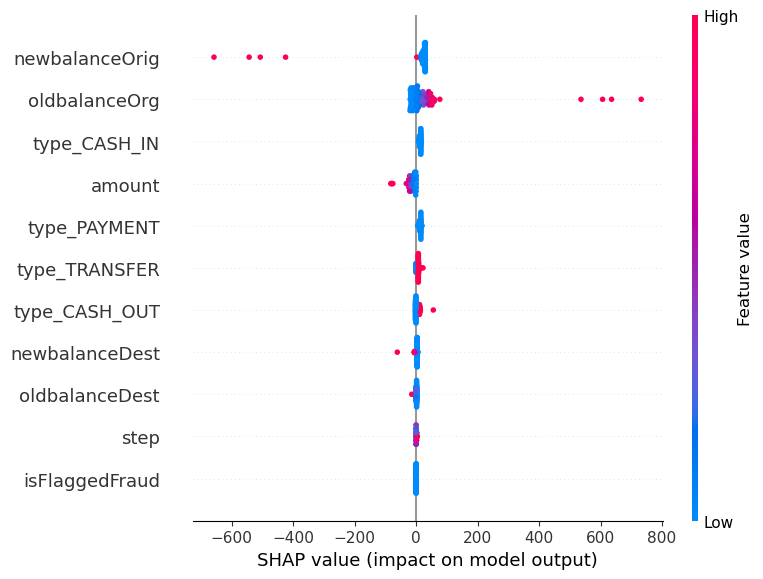

In [107]:
# Plot a summary plot.
sm.plot_summary('summary', 30, None)

Easily Restore the data after operations.

Error in stacked_group: need at least one array to concatenate


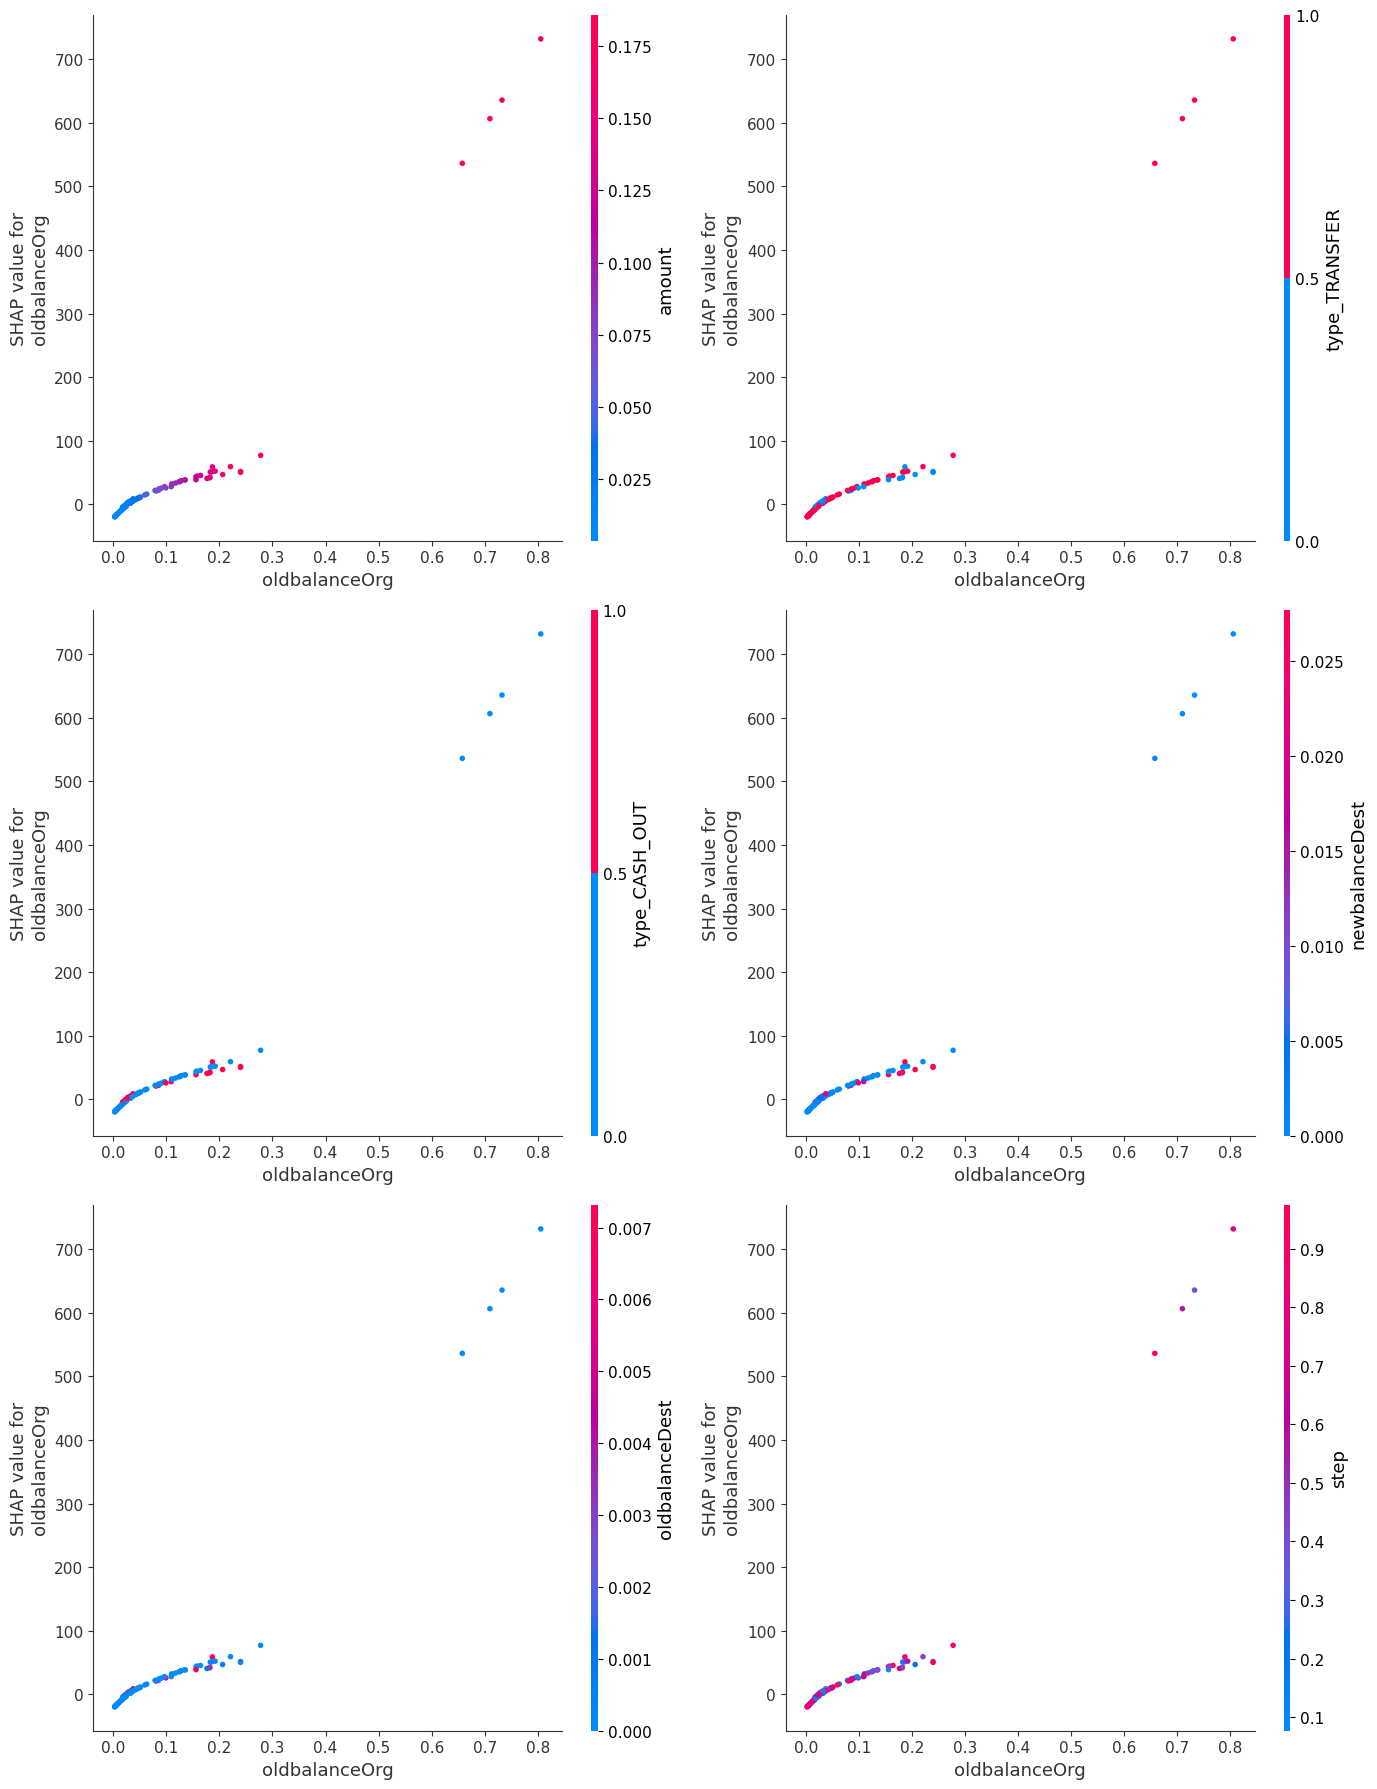

In [109]:
#sm.restore_data()
#print(sm.data.head())  # or any other way to inspect the data

#sm.restore_data()
#sm.stacked_group('dst_port', 30, 'average')
#sm.plot_dependence('dst_port', 6)

#I was getting an error in the stacked group I wasnt sure why, can investigate further if we need to.
try:
    sm.restore_data()
except Exception as e:
    print(f"Error in restoring data: {e}")

try:
    sm.stacked_group('oldbalanceOrg', 30, 'average')
except Exception as e:
    print(f"Error in stacked_group: {e}")

try:
    sm.plot_dependence('oldbalanceOrg', 6)
except Exception as e:
    print(f"Error in plot_dependence: {e}")